# 1. 검증용 데이터셋 준비

In [19]:
import os
 
img_dir = os.getenv('HOME')+'/aiffel/ocr_python/ocrimg'
img_list = os.listdir(img_dir)
img_list

['ocrimg3.png', 'ocrimg4.png', 'ocrimg2.png', 'ocrimg1.png']

# 2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

+ 2-1. Google OCR API

In [10]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [11]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
#!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

for img in img_list:
    print(f'[{img}]')
    detect_text(os.path.join(img_dir, img))
    print()

[ocrimg3.png]
Texts:

"EAST
ALXT
PHA
ano
THE LESSER KEY
OF SOLOMON
Goetia: The Book of Evil Spirits
Lemegeton - Clavicula Salomonis Regis
S. L. MacGregor Mathers
&
Aleister Crowley
SOUTH
"

"EAST"

"ALXT"

"PHA"

"ano"

"THE"

"LESSER"

"KEY"

"OF"

"SOLOMON"

"Goetia:"

"The"

"Book"

"of"

"Evil"

"Spirits"

"Lemegeton"

"-"

"Clavicula"

"Salomonis"

"Regis"

"S."

"L."

"MacGregor"

"Mathers"

"&"

"Aleister"

"Crowley"

"SOUTH"
bounds: (453,301),(451,327),(446,327),(448,301)

[ocrimg4.png]
Texts:

"the £ on Earned Incomes 1s. per ton on . JA
THE TWO RECORDS
COMPARE THEM!
Tory (1895-1905) Liberal (1906-1908)
Taxation.
Taxation.
Extra taxes put on amounting to
Existing taxes taken off amounting to
8 millions a year.
24 millions a year.
2d. per pound on Tea. jd. per pound on Sugar, 4d. in
id. per pound on Tea, d. per pound on
Coal
.in
the £ on Incomes, is per ton on Exported Coal, extra
duties on Beer and Spirits.
National Debt.
National Debt.
Made bigger by 137 millions.
Made less b

+ 2-2. keras-ocr

In [12]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [13]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 

images = [ keras_ocr.tools.read(os.path.join(img_dir,img)) for img in img_list]
prediction_groups = [pipeline.recognize([os.path.join(img_dir,img)]) for img in img_list]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


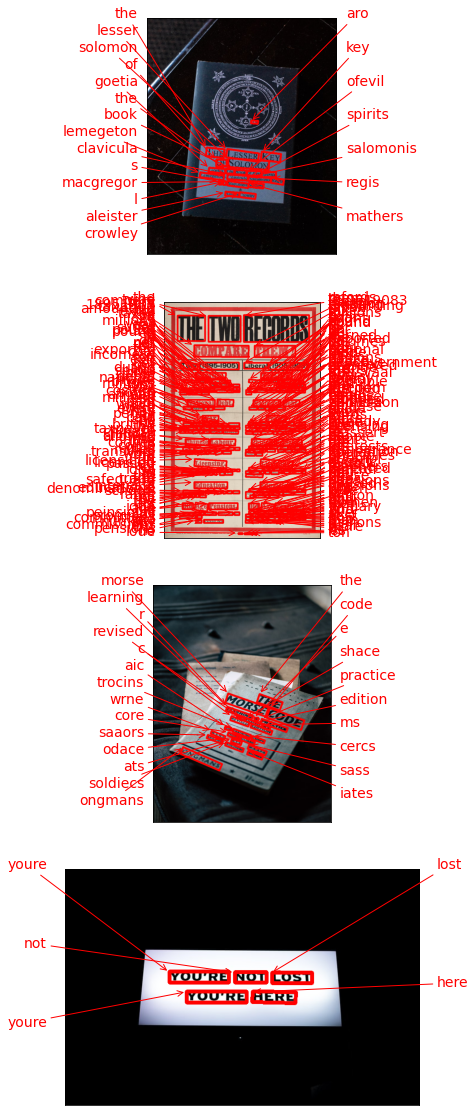

In [14]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

+ 2-3. Tesseract

In [40]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
        #    print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")


save_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract_save'

for img in img_list:
    print(f'[{img}]')
    cropped_image_path_list = crop_word_regions(os.path.join(img_dir, img),save_dir)
    recognize_images(cropped_image_path_list)

[ocrimg3.png]
LHR

LESSER

ae

(FR

SOLON

|

Done
[ocrimg4.png]

PG

Vent

a

-OR

BLESSING

Wie

MUCH

MORE

a

THAN | DESERVE

,

Done
[ocrimg2.png]

Done
[ocrimg1.png]
YOU'RE

MOT

1 Ost

YOU'RE

rte Ee.

MNYOU'RE HERE

Done


# 3. 테스트 결과 정리

In [46]:
def results_compare(file):
    print('\n[Google OCR]')
    detect_text(os.path.join(img_dir, file))
    print('[keras-ocr]')
    idx = img_list.index(file)
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
    plt.show()
    print('\n[Tesseract]')
    cropped_image_path_list = crop_word_regions(os.path.join(img_dir, file),save_dir)
    recognize_images(cropped_image_path_list)


[Google OCR]
Texts:

"YOU'RE NOT LOST
YOU'RE HERE
"

"YOU'RE"

"NOT"

"LOST"

"YOU'RE"

"HERE"
bounds: (339,223),(414,224),(414,240),(339,239)
[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


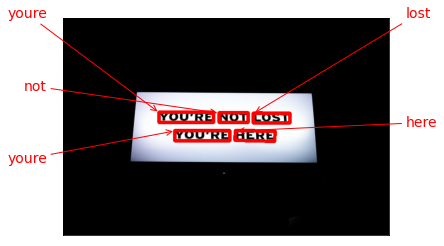


[Tesseract]
YOU'RE

MOT

1 Ost

YOU'RE

rte Ee.

MNYOU'RE HERE

Done


In [47]:
results_compare('ocrimg1.png')


[Google OCR]
Texts:

"THE
MORSE CODE
LEARNING & PRACTICE
RG SHACKEL, MA
REVISED EDITION
AIR TRAINING CORPS
HOME GUARD
W.R.N.S
A.T.S.
WAARS
SAILORS
SOLDIERS
AIRMEN
LONGMANS
"

"THE"

"MORSE"

"CODE"

"LEARNING"

"&"

"PRACTICE"

"RG"

"SHACKEL,"

"MA"

"REVISED"

"EDITION"

"AIR"

"TRAINING"

"CORPS"

"HOME"

"GUARD"

"W.R.N.S"

"A.T.S."

"WAARS"

"SAILORS"

"SOLDIERS"

"AIRMEN"

"LONGMANS"
bounds: (97,582),(242,644),(235,662),(90,599)
[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


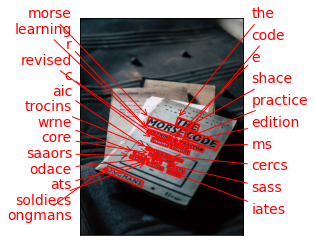


[Tesseract]

Done


In [48]:
results_compare('ocrimg2.png')


[Google OCR]
Texts:

"EAST
ALXT
PHA
ano
THE LESSER KEY
OF SOLOMON
Goetia: The Book of Evil Spirits
Lemegeton - Clavicula Salomonis Regis
S. L. MacGregor Mathers
&
Aleister Crowley
SOUTH
"

"EAST"

"ALXT"

"PHA"

"ano"

"THE"

"LESSER"

"KEY"

"OF"

"SOLOMON"

"Goetia:"

"The"

"Book"

"of"

"Evil"

"Spirits"

"Lemegeton"

"-"

"Clavicula"

"Salomonis"

"Regis"

"S."

"L."

"MacGregor"

"Mathers"

"&"

"Aleister"

"Crowley"

"SOUTH"
bounds: (453,301),(451,327),(446,327),(448,301)
[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


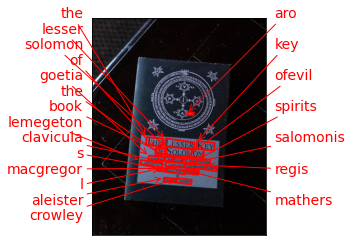


[Tesseract]
LHR

LESSER

ae

(FR

SOLON

|

Done


In [49]:
results_compare('ocrimg3.png')


[Google OCR]
Texts:

"THANK YOU
GOD
FOR BLESSING ME
MUCH MORE
THAN I DESERVE
"

"THANK"

"YOU"

"GOD"

"FOR"

"BLESSING"

"ME"

"MUCH"

"MORE"

"THAN"

"I"

"DESERVE"
bounds: (309,565),(560,566),(560,617),(309,616)
[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


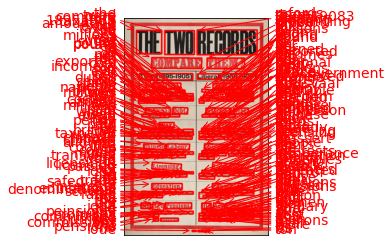


[Tesseract]

PG

Vent

a

-OR

BLESSING

Wie

MUCH

MORE

a

THAN | DESERVE

,

Done


In [50]:
results_compare('ocrimg4.png')

# 4. 결과 분석과 결론 제시

+ 정방향의 이미지
+ 삐뚫어진 이미지
+ 작은 글자의 이미지
+ 정방향이지만 무수히 많고 작은 글자들의 이미지

이렇게 네가지의 이미지를 대상으로 Google OCR,keras-ocr,Tesseract 모두 실험을 해보았는데
Google OCR이 모든 면에서 다 적절한 결과를 뽑아내었습니다.   
google -> keras -> tesseract 순으로 인식이 잘되었고 google ocr을 활용해서 목표로하는 서비스에 다가가면 높은 결과를 도출할 수 있을 것 같다.